In [1]:
import numpy as np

import scoobpsf
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import *
import scoobpsf.compact_scoob as cscoob
import scoobpsf.dm as dm

from importlib import reload

import lina

pupil_diam = 6.5*u.m
wavelength = 700e-9*u.m
npix = 512
oversample = 1

pxscl = pupil_diam.to_value(u.m)/npix

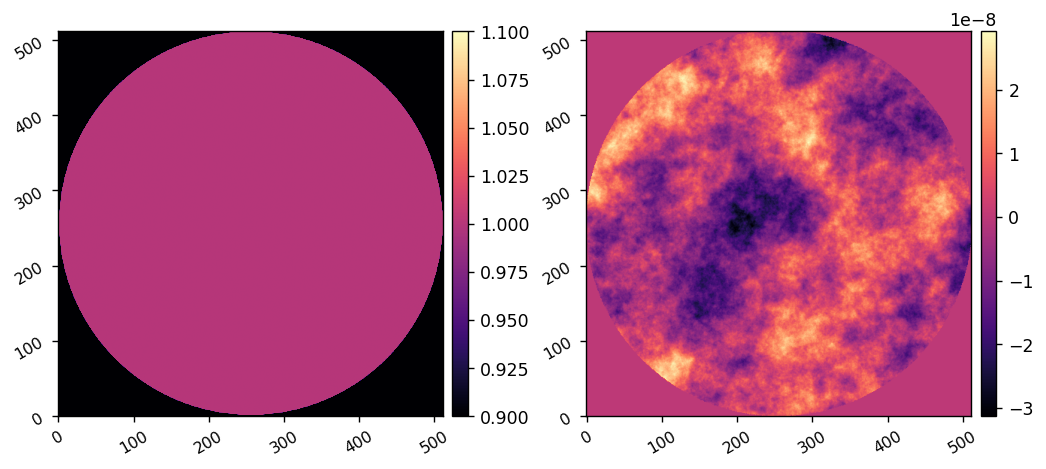

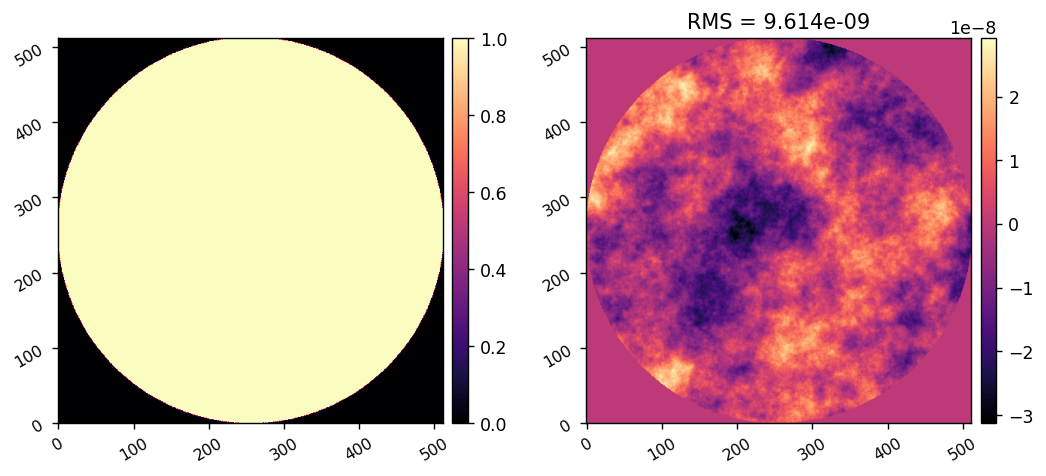

In [2]:
WFE = lina.utils.generate_wfe(pupil_diam, wavelength=wavelength,
                                opd_index=3.0, amp_index=3.0, 
                                opd_seed=1234, amp_seed=12345,
                                opd_rms=10*u.nm, amp_rms=0.0,
                                npix=npix, oversample=oversample,
                                plot=True)


mask = xp.abs(WFE).astype(bool)
opd = xp.angle(WFE)*wavelength.to_value(u.m)/(2*np.pi)

rms = xp.sqrt(xp.mean(opd[mask]**2))

imshow2(mask, opd, None, f'RMS = {rms:.3e}')



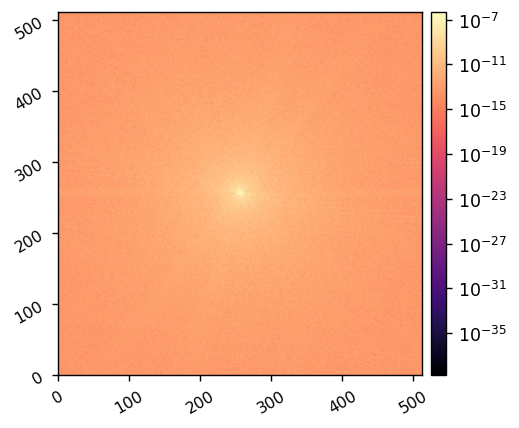

In [3]:
psd2d = xp.abs(xp.fft.fftshift(xp.fft.fft2(opd)))**2

imshow1(psd2d, lognorm=True)

In [4]:
def psd_profile(psd2d, nbins, cenyx=None, scaleyx=(1.0, 1.0)):
    indices = np.indices(psd2d.shape)
    if cenyx is None:
        cenyx = ( (psd2d.shape[0] - 1) / 2., (psd2d.shape[1] - 1)  / 2.)
    radial = np.sqrt( (scaleyx[0]*(indices[0] - cenyx[0]))**2 + (scaleyx[1]*(indices[1] - cenyx[1]))**2 )

    bins = np.linspace(0, radial.max(), num=nbins, endpoint=True)
    digrad = np.digitize(radial, bins)
    profile = np.asarray([np.mean(ensure_np_array(psd2d[ (digrad == i)])) for i in np.unique(digrad)])
    return profile



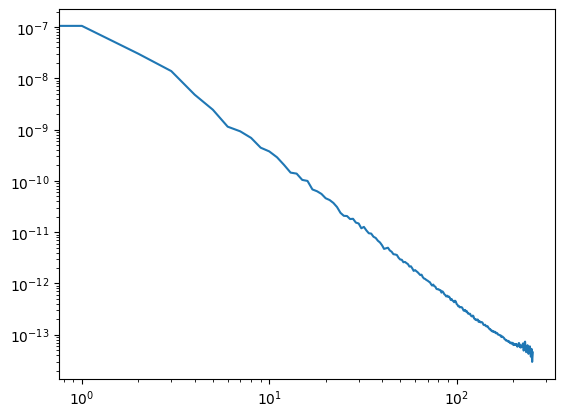

In [5]:
psd = psd_profile(psd2d, 256)
plt.loglog(psd)

# bins, contrast = get_radial_contrast(im, mask, nbins=nbins, cenyx=cenyx)

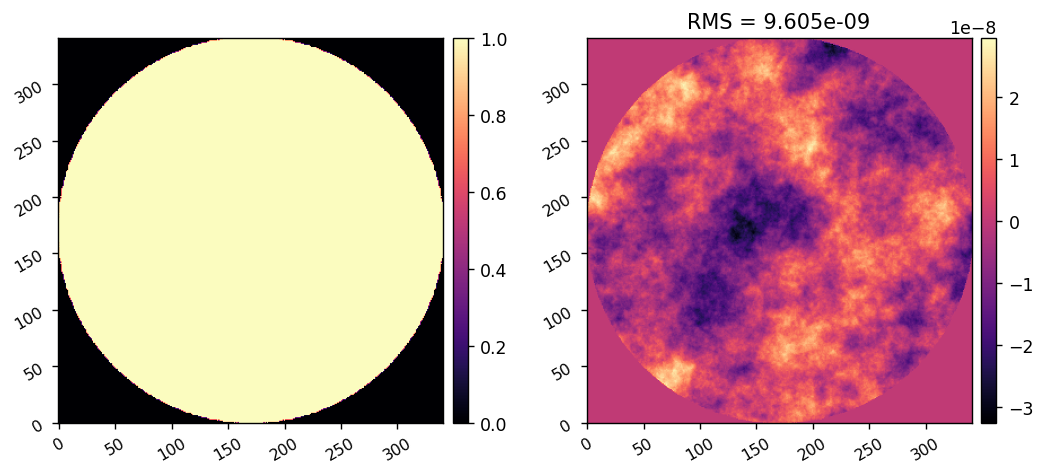

In [6]:

new_pxscl = 1.5*pupil_diam.to_value(u.m)/npix

imask = scoobpsf.utils.interp_arr(mask, pixelscale=pxscl, new_pixelscale=new_pxscl, order=0)
iopd = scoobpsf.utils.interp_arr(opd, pixelscale=pxscl, new_pixelscale=new_pxscl)

irms = xp.sqrt(xp.mean(iopd[imask]**2))

imshow2(imask, iopd, None, f'RMS = {irms:.3e}')


In [23]:
iopd.shape[0]/2

170.5

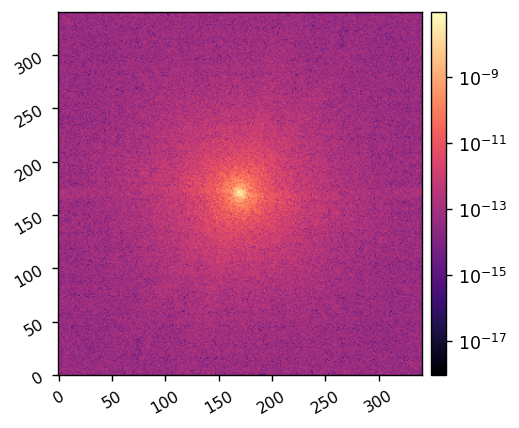

In [7]:
ipsd2d = xp.abs(xp.fft.fftshift(xp.fft.fft2(iopd)))**2

imshow1(ipsd2d, lognorm=True)

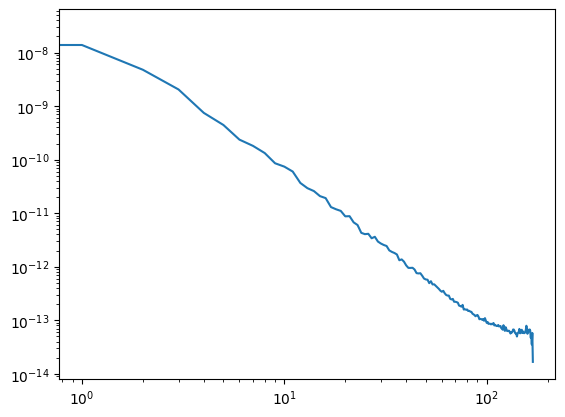

In [11]:
ipsd = psd_profile(ipsd2d, 170)
plt.loglog(ipsd)

Text(0.5, 0, 'bins')

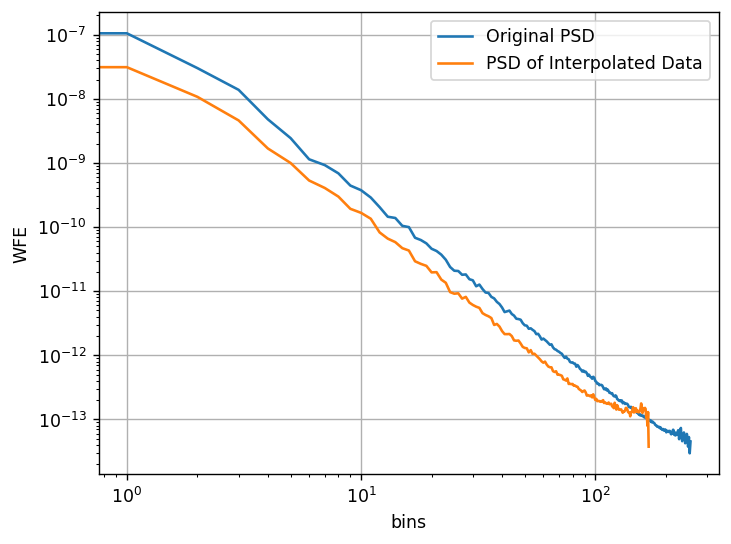

In [13]:
plt.figure(dpi=125)
plt.loglog(psd, label='Original PSD')
plt.loglog(ipsd, label='PSD of Interpolated Data')
plt.grid()
plt.legend()
plt.ylabel('WFE')
plt.xlabel('bins')